# Overfitting II

Last time, we saw a theoretical example of *overfitting*, in which we fit a machine learning model that perfectly fit the data it saw, but performed extremely poorly on fresh, unseen data. In this lecture, we'll observe overfitting in a more practical context, using the Titanic data set again. We'll then begin to study *validation* techniques for finding models with "just the right amount" of flexibility. 

In [5]:
#Standard imports
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

__Before we get started:__ make sure the file titanic.csv is in the same folder as this notebook

In [6]:
titanic=pd.read_csv("titanic.csv")


__Before:__ We diagnosed overfitting by testing our model against some new data.

__Here:__ We don't have any more data. 

__Solution:__ Hold out some data that we won't let our model see at first. This holdout data is called the *validation* or *testing* data, depending on the use to which we put it. In contrast, the data that we allow our model to see is called the *training* data.

`sklearn.model_selection` provides a convenient function for partitioning our data into training and holdout sets called `train_test_split`. The default and generally most useful behavior is to randomly select rows of the data frame to be in each set. 

In [7]:
from sklearn.model_selection import train_test_split

np.random.seed(1234)
train,test=train_test_split(titanic,test_size=.3)
train.shape, test.shape

((620, 8), (267, 8))

Now we have two data frames. As you may recall from a previous lecture, we need to do some data cleaning, and split them into predictor variables `X` and target variables `y`. Since we are going to preprocess two data frames, let's write a function.

In [8]:
from sklearn import preprocessing

def prep_titanic_data(data):
    #in order to modify a data frame inside a function we need to copy it
    df=data.copy()
    
    #change female/male to 0's and 1's
    le = preprocessing.LabelEncoder()
    df['Sex'] = le.fit_transform(df['Sex'])
    
    #don't need name
    df=df.drop(['Name'],axis=1)
    
    #split into X and y
    X=df.drop(['Survived'],axis=1)
    y=df['Survived']
    
    return(X,y)

Now, let's apply this function to both dataframes

In [9]:
X_train,y_train=prep_titanic_data(train)
X_test,y_test=prep_titanic_data(test)


Now we're able to train our model on the `train` data, and then evaluate its performance on the `val` data. This will help us to diagnose and avoid overfitting.

Let's try using the decision tree classifier again. As you may remember, the `DecisionTreeClassifier()` class takes an argument `max_depth` that governs how many layers of decisions the tree is allowed to make. Larger `max_depth` values correspond to more complicated trees. In this way, `max_depth` is a model complexity parameter, similar to the `degree` when we did polynomial regression. 

For example, with a small `max_depth`, the model scores on the training and validation data are relatively close. 

In [10]:
from sklearn import tree

T = tree.DecisionTreeClassifier(max_depth = 3)

T.fit(X_train, y_train)
T.score(X_train, y_train), T.score(X_test, y_test)

(0.8290322580645161, 0.8164794007490637)

Now, let's try it with a larger max_depth

In [11]:
T = tree.DecisionTreeClassifier(max_depth = 20)

T.fit(X_train, y_train)
T.score(X_train, y_train), T.score(X_test, y_test)

(0.9903225806451613, 0.7602996254681648)

The model with max depth too large overfits the data. Let's flesh this out in a bit more detail.

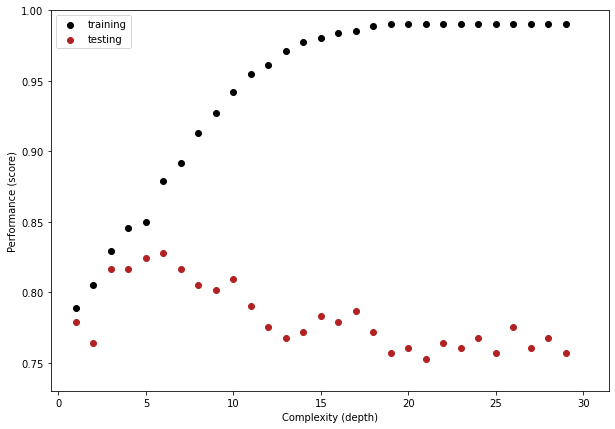

In [12]:

N=30 #largest max_depth
training_scores=np.zeros(N)
testing_scores=np.zeros(N)
depths=np.arange(1,31)


for d in range(1, 30):
    T = tree.DecisionTreeClassifier(max_depth = d)
    T.fit(X_train, y_train)
    training_scores[d-1]=T.score(X_train,y_train)
    testing_scores[d-1]=T.score(X_test,y_test)
    
    
fig, ax = plt.subplots(1, figsize = (10, 7))
    
ax.scatter(depths,training_scores,color="black",label="training")
ax.scatter(depths,testing_scores,color="firebrick",label="testing")    
ax.set(xlabel = "Complexity (depth)", ylabel = "Performance (score)",ylim=(.73,1))
ax.legend()

Observe that the training score (black) always increases, while the test score (red) tops out around 83\% and then even begins to trail off slightly. It looks like the optimal depth might be around 5-7 or so, but there's some random noise that can prevent us from being able to determine exactly what the optimal depth is. 

Increasing performance on the training set combined with decreasing performance on the test set is the trademark of overfitting. 

This noise reflects the fact that we took a single, random subset of the data for testing. In a more systematic experiment, we would draw many different subsets of the data for each value of depth and average over them. This is what *cross-validation* does, and we'll talk about it in the next lecture.